# 11 - Phonons

This script demonstrates phonon calculations using the finite displacement
method with Phonopy. Calculates phonon dispersion and density of states
for silicon.
    
    
Requires:
    pip install phonopy

In [1]:
import numpy as np
from ase.build import bulk

from vasp import Vasp

# Check for phonopy
try:
    import phonopy
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms
    HAS_PHONOPY = True
except ImportError:
    HAS_PHONOPY = False
    print("Note: phonopy not found. Install with: pip install phonopy")

# Check for matplotlib
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False

print("=" * 60)
print("Phonon Calculations")
print("=" * 60)
print()

if not HAS_PHONOPY:
    print("This example requires phonopy. Please install it:")
    print("  pip install phonopy")
    print()
    print("Phonon calculations allow you to compute:")
    print("  - Vibrational frequencies")
    print("  - Thermal properties (heat capacity, entropy)")
    print("  - Zero-point energy")
    print("  - Phonon band structure and DOS")
    exit(0)


Phonon Calculations



## Part 1: Create structure and supercell


In [2]:
print("Part 1: Setup structure")
print("-" * 40)
print()

# Create silicon primitive cell
si = bulk('Si', 'diamond', a=5.43)
print(f"Primitive cell: {len(si)} atoms")
print()

# Define supercell matrix
supercell_matrix = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
print(f"Supercell: 2×2×2 = {2**3} primitive cells")
print()

# Convert ASE atoms to Phonopy format
def ase_to_phonopy(atoms):
    """Convert ASE Atoms to PhonopyAtoms."""
    return PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.cell,
        scaled_positions=atoms.get_scaled_positions(),
    )

phonopy_atoms = ase_to_phonopy(si)
phonon = Phonopy(phonopy_atoms, supercell_matrix)

# Generate displaced supercells
phonon.generate_displacements(distance=0.01)  # 0.01 Å displacement
supercells = phonon.supercells_with_displacements

print(f"Number of displaced supercells: {len(supercells)}")
print(f"Atoms per supercell: {len(supercells[0])}")
print()


Part 1: Setup structure
----------------------------------------

Primitive cell: 2 atoms

Supercell: 2×2×2 = 8 primitive cells

Number of displaced supercells: 1
Atoms per supercell: 16



## Part 2: Calculate forces for each displacement


In [3]:
print("Part 2: Force calculations")
print("-" * 40)
print()

def phonopy_to_ase(phonopy_atoms):
    """Convert PhonopyAtoms to ASE Atoms."""
    from ase import Atoms
    return Atoms(
        symbols=phonopy_atoms.symbols,
        cell=phonopy_atoms.cell,
        scaled_positions=phonopy_atoms.scaled_positions,
        pbc=True,
    )

forces_sets = []

for i, sc in enumerate(supercells):
    print(f"  Calculating displacement {i+1}/{len(supercells)}...")

    atoms = phonopy_to_ase(sc)

    calc = Vasp(
        label=f'results/phonons/disp_{i:03d}',
        atoms=atoms,
        xc='PBE',
        encut=400,
        kpts=(4, 4, 4),  # Reduced k-points for supercell
        ismear=0,
        sigma=0.05,
        ibrion=-1,  # No ionic relaxation
        nsw=0,
    )

    atoms.calc = calc
    forces = atoms.get_forces()
    forces_sets.append(forces)

print()
print(f"Collected forces for {len(forces_sets)} configurations")
print()


Part 2: Force calculations
----------------------------------------

  Calculating displacement 1/1...

Collected forces for 1 configurations



## Part 3: Calculate phonon properties


In [4]:
print("Part 3: Phonon analysis")
print("-" * 40)
print()

# Set forces in phonopy
phonon.forces = forces_sets

# Calculate force constants
phonon.produce_force_constants()
print("Force constants calculated")
print()

# Set up mesh for DOS
mesh = [20, 20, 20]
phonon.run_mesh(mesh)
print(f"Phonon mesh: {mesh}")

# Calculate total DOS
phonon.run_total_dos()
total_dos = phonon.total_dos

# Get frequencies at Gamma
phonon.run_qpoints([[0, 0, 0]])
gamma_freqs = phonon.get_qpoints_dict()['frequencies'][0]

print()
print("Phonon frequencies at Γ point (THz):")
for i, freq in enumerate(gamma_freqs):
    mode_type = "acoustic" if abs(freq) < 0.5 else "optical"
    print(f"  Mode {i+1}: {freq:8.4f} THz ({mode_type})")

print()

# Optical phonon frequency
optical_freqs = [f for f in gamma_freqs if abs(f) > 0.5]
if optical_freqs:
    print(f"Optical phonon frequency: {optical_freqs[0]:.2f} THz")
    print("Experimental: 15.5 THz")
print()


Part 3: Phonon analysis
----------------------------------------

Force constants calculated

Phonon mesh: [20, 20, 20]

Phonon frequencies at Γ point (THz):
  Mode 1:  -0.0000 THz (acoustic)
  Mode 2:  -0.0000 THz (acoustic)
  Mode 3:  -0.0000 THz (acoustic)
  Mode 4:  15.3804 THz (optical)
  Mode 5:  15.3804 THz (optical)
  Mode 6:  15.3804 THz (optical)

Optical phonon frequency: 15.38 THz
Experimental: 15.5 THz



## Part 4: Thermal properties


In [5]:
print("Part 4: Thermal properties")
print("-" * 40)
print()

# Calculate thermal properties
phonon.run_thermal_properties(t_min=0, t_max=800, t_step=10)

# Get thermal properties as dict with keys: temperatures, free_energy, entropy, heat_capacity
tp = phonon.get_thermal_properties_dict()
temps = tp['temperatures']
free_energy = tp['free_energy']
entropy = tp['entropy']
heat_capacity = tp['heat_capacity']

# Room temperature values
idx_300K = np.argmin(np.abs(temps - 300))

print("At T = 300 K:")
print(f"  Free energy: {free_energy[idx_300K]:.3f} kJ/mol")
print(f"  Entropy: {entropy[idx_300K]:.3f} J/mol/K")
print(f"  Heat capacity: {heat_capacity[idx_300K]:.3f} J/mol/K")
print("  Experimental Cv: ~20 J/mol/K")
print()

# Zero-point energy
zpe = free_energy[0]  # At T=0
print(f"Zero-point energy: {zpe:.3f} kJ/mol")
print()

Part 4: Thermal properties
----------------------------------------

At T = 300 K:
  Free energy: 6.402 kJ/mol
  Entropy: 40.505 J/mol/K
  Heat capacity: 39.514 J/mol/K
  Experimental Cv: ~20 J/mol/K

Zero-point energy: 11.907 kJ/mol



## Part 5: Phonon band structure


In [6]:
print("Part 5: Phonon band structure")
print("-" * 40)
print()

# Set up band structure path for FCC
band_labels = ['$\\Gamma$', 'X', 'U|K', '$\\Gamma$', 'L']
bands = [
    [[0, 0, 0], [0.5, 0, 0.5]],        # Gamma -> X
    [[0.5, 0, 0.5], [0.625, 0.25, 0.625]],  # X -> U
    [[0.375, 0.375, 0.75], [0, 0, 0]],  # K -> Gamma
    [[0, 0, 0], [0.5, 0.5, 0.5]],       # Gamma -> L
]

phonon.run_band_structure(bands, with_eigenvectors=False, labels=band_labels)
band_dict = phonon.get_band_structure_dict()

print("Band structure calculated along:")
print("  Γ → X → U|K → Γ → L")
print()


Part 5: Phonon band structure
----------------------------------------

Band structure calculated along:
  Γ → X → U|K → Γ → L



## Part 6: Plot results


Part 6: Generating plots
----------------------------------------

  Saved plot: silicon_phonons.png



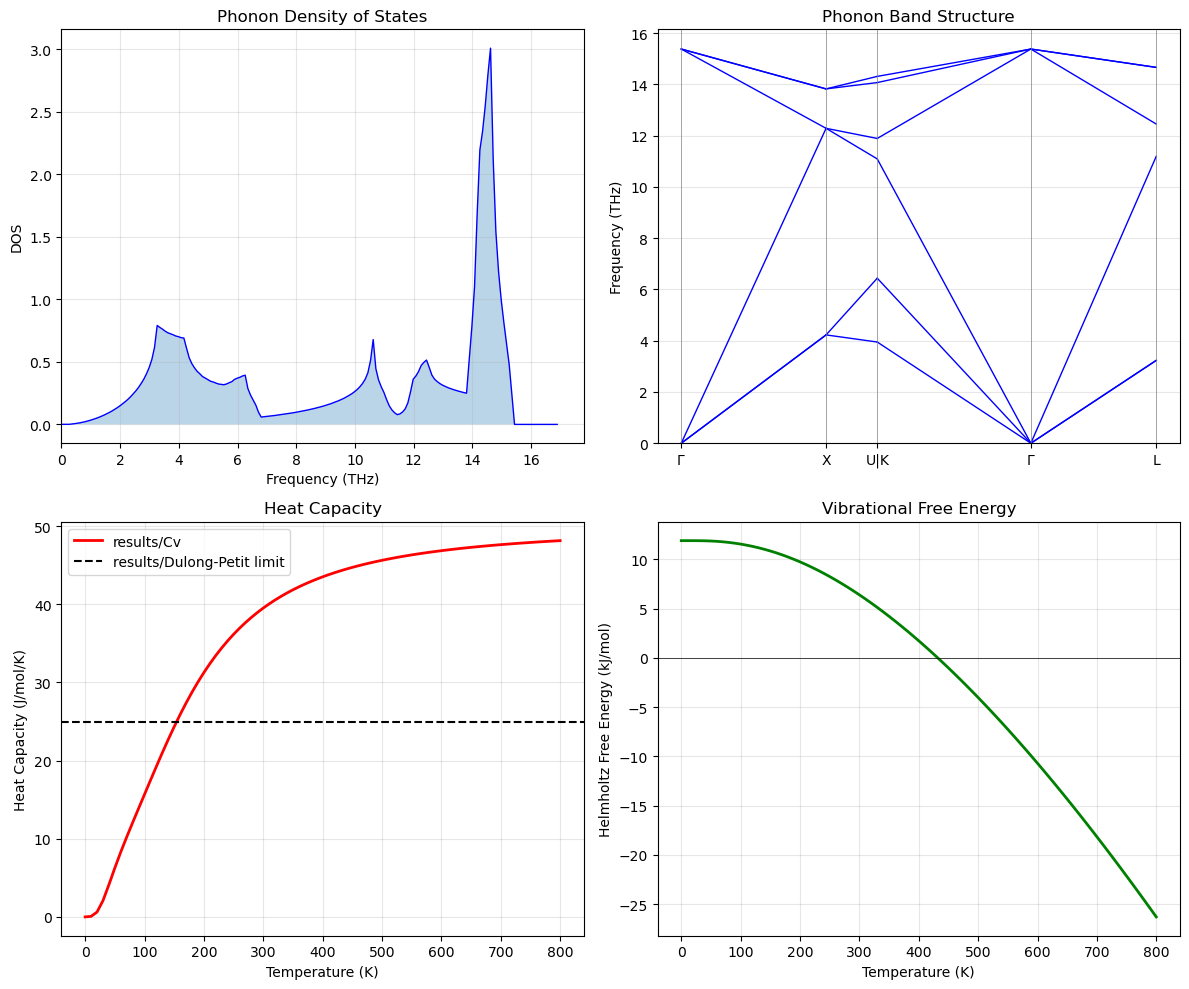

In [7]:
if HAS_MATPLOTLIB:
    print("Part 6: Generating plots")
    print("-" * 40)
    print()

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Phonon DOS
    ax1 = axes[0, 0]
    freq_points = total_dos.frequency_points
    dos_values = total_dos.dos
    ax1.fill_between(freq_points, 0, dos_values, alpha=0.3)
    ax1.plot(freq_points, dos_values, 'b-', linewidth=1)
    ax1.set_xlabel('Frequency (THz)')
    ax1.set_ylabel('DOS')
    ax1.set_title('Phonon Density of States')
    ax1.set_xlim(0, None)
    ax1.grid(True, alpha=0.3)

    # Phonon band structure
    ax2 = axes[0, 1]
    distances = band_dict['distances']
    frequencies = band_dict['frequencies']

    for segment_distances, segment_freqs in zip(distances, frequencies):
        for band in range(segment_freqs.shape[1]):
            ax2.plot(segment_distances, segment_freqs[:, band], 'b-', linewidth=1)

    # Add labels
    special_points = [0]
    for d in distances:
        special_points.append(d[-1])
    ax2.set_xticks(special_points)
    ax2.set_xticklabels(band_labels)
    for sp in special_points:
        ax2.axvline(x=sp, color='gray', linestyle='-', linewidth=0.5)

    ax2.set_ylabel('Frequency (THz)')
    ax2.set_title('Phonon Band Structure')
    ax2.set_ylim(0, None)
    ax2.grid(True, axis='y', alpha=0.3)

    # Thermal properties
    ax3 = axes[1, 0]
    ax3.plot(temps, heat_capacity, 'r-', linewidth=2, label='results/Cv')
    ax3.axhline(y=24.94, color='k', linestyle='--', label='results/Dulong-Petit limit')
    ax3.set_xlabel('Temperature (K)')
    ax3.set_ylabel('Heat Capacity (J/mol/K)')
    ax3.set_title('Heat Capacity')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Free energy
    ax4 = axes[1, 1]
    ax4.plot(temps, free_energy, 'g-', linewidth=2)
    ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax4.set_xlabel('Temperature (K)')
    ax4.set_ylabel('Helmholtz Free Energy (kJ/mol)')
    ax4.set_title('Vibrational Free Energy')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('silicon_phonons.png', dpi=150)
    print("  Saved plot: silicon_phonons.png")
    print()


## Summary


In [8]:
print("=" * 60)
print("Summary")
print("=" * 60)
print()
print("Silicon phonon properties:")
print(f"  Optical frequency at Γ: {optical_freqs[0]:.1f} THz (exp: 15.5 THz)")
print(f"  Zero-point energy: {zpe:.1f} kJ/mol")
print(f"  Heat capacity (300K): {heat_capacity[idx_300K]:.1f} J/mol/K")
print()
print("Key points:")
print("  - Use finite displacement method with Phonopy")
print("  - Supercell size affects accuracy")
print("  - Include ZPE for accurate thermodynamics")
print("  - Phonon dispersion reveals lattice dynamics")
print()
print("Next: Try 12_dft_plus_u/ for strongly correlated systems.")


Summary

Silicon phonon properties:
  Optical frequency at Γ: 15.4 THz (exp: 15.5 THz)
  Zero-point energy: 11.9 kJ/mol
  Heat capacity (300K): 39.5 J/mol/K

Key points:
  - Use finite displacement method with Phonopy
  - Supercell size affects accuracy
  - Include ZPE for accurate thermodynamics
  - Phonon dispersion reveals lattice dynamics

Next: Try 12_dft_plus_u/ for strongly correlated systems.
